### Helper Functions and imports

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from scipy.optimize import minimize

In [2]:
def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

In [3]:
def normalize_grid(data):
    return np.log(data)

In [4]:
def objective(x):
    a = int(x[0])
    b = int(x[1])
    return float(s_grid_values[a, b] + p_grid_values[a, b] + d_grid_values[a, b])

In [5]:
def get_grids_percent(e_grid_values, grid_values, rads):
    if np.sum(grid_values[rads]) == 0:
        return 1
    return np.sum(e_grid_values[rads]) / np.sum(grid_values[rads])

### Load Data

In [6]:
s_grid_file = open('non_zero Насыщенность', 'r')
p_grid_file = open('non_zero Пористость', 'r')
d_grid_file = open('non_zero Толщины', 'r')

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 238655.03it/s]


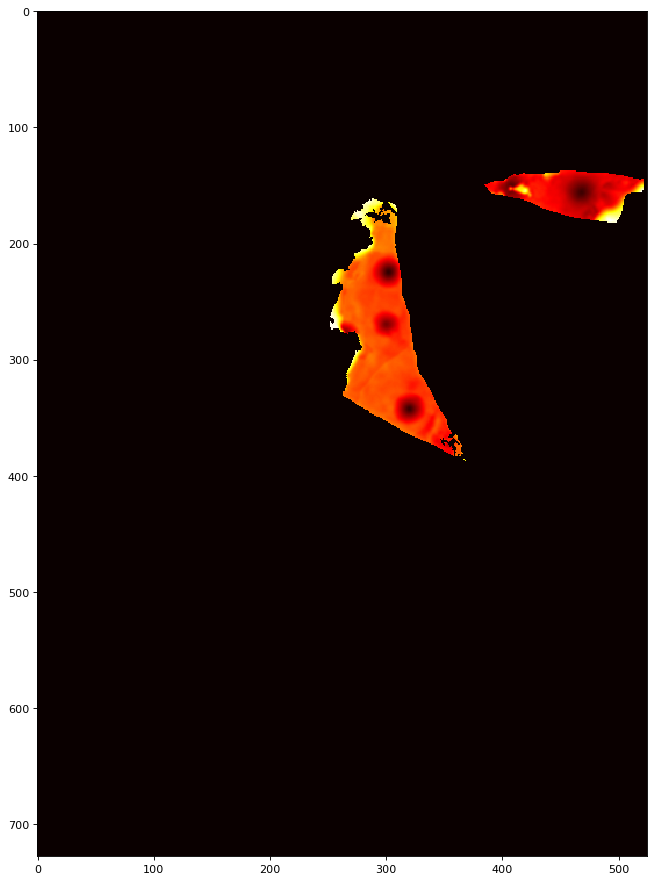

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 230868.08it/s]


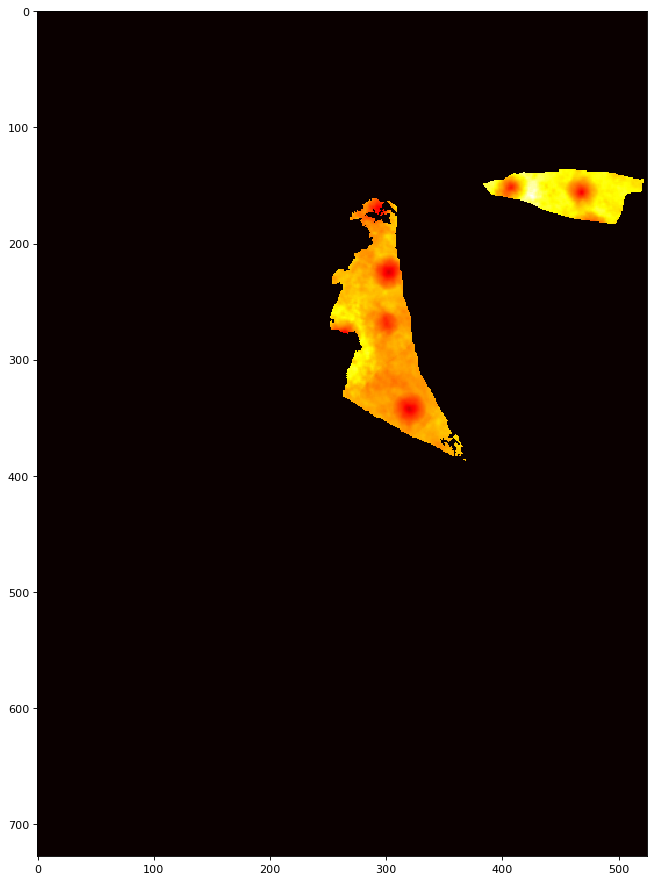

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 232563.77it/s]


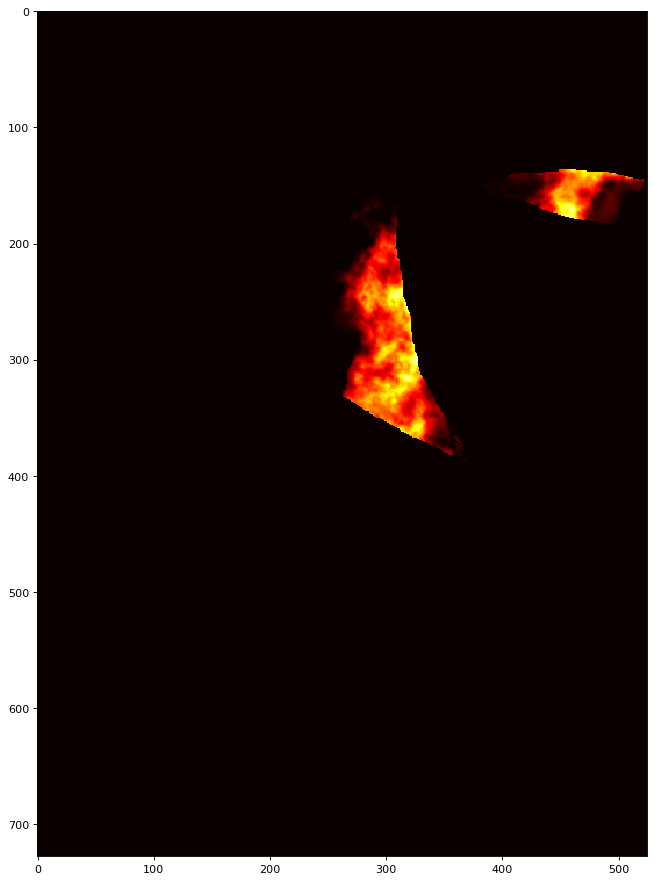

In [7]:
grids = []
for grid_file in [s_grid_file, p_grid_file, d_grid_file]:
    lines = grid_file.readlines()
    for i in range (0, len(lines)):
        lines[i] = lines[i].replace('\n', '')
    
    numX = int(lines[0].split(' ')[1])
    numY = int(lines[2].split(' ')[0])
    b_lines = lines[4:]
    print('x size:', numX)
    print('y size:', numY)
    len(b_lines) * 6 == numX*numY
    
    grid_values = np.zeros((numX, numY)) 
    x_i = 0
    y_i = 0

    for l in tqdm(b_lines):
        values = l.split(' ')
        for val in values:
            if int(float(val)) != 9999900:
                grid_values[x_i][y_i] = float(val)

            y_i += 1
            if y_i == numY:
                y_i = 0
                x_i += 1
    
    grid_values = np.fliplr(grid_values[::-1,::-1])
    figure(figsize=(16, 14), dpi=80)
    plt.imshow(grid_values, cmap='hot', interpolation='none')
    plt.show()
    grids.append(grid_values)

In [8]:
s_grid_values = grids[0]
p_grid_values = grids[1]
d_grid_values = grids[2]

print(s_grid_values.shape == p_grid_values.shape)
print(s_grid_values.shape == d_grid_values.shape)

True
True


In [9]:
#s_grid_values = normalize_grid(s_grid_values)
#p_grid_values = normalize_grid(p_grid_values)
#d_grid_values = normalize_grid(d_grid_values)

### Parameters set

In [10]:
r = 5. # radius
b_percent = 0 # percent threshold (in %)

### Robust algorithm

In [11]:
x = np.arange(0, numX)
y = np.arange(0, numY)

In [12]:
optimization_dict = {}

In [23]:
robust_well_coords = (0, 0)
max_robust_percentage = 0
sum_percent = 0
optimized_zone = []

p_flag = True
all_ok = False

s_optimized_grid_values = s_grid_values
p_optimized_grid_values = p_grid_values
d_optimized_grid_values = d_grid_values

for i in tqdm(range(0, len(s_grid_values))):
    for j in range(0, len(s_grid_values[i])):
        if s_grid_values[i][j] < 0.1 or p_grid_values[i][j] < 0.1 or d_grid_values[i][j] < 0.1:
            continue
        
        c_s_grid_values = s_grid_values.copy()
        c_p_grid_values = p_grid_values.copy()
        c_d_grid_values = d_grid_values.copy()
        
        cx = float(j)
        cy = float(i)
        mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
        rad_flag = False
        for b in (c_s_grid_values[mask]):
            if b < 0.1:
                rad_flag = True
                break
        for b in (c_p_grid_values[mask]):
            if b < 0.1:
                rad_flag = True
                break
        for b in (c_d_grid_values[mask]):
            if b < 0.1:
                rad_flag = True
                break
                
        if rad_flag:
            continue
        
        sigmoid_rad = []
        for b in c_s_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
            
        c_s_grid_values[mask] = sigmoid_rad
        
        sigmoid_rad = []
        for b in c_p_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
            
        c_p_grid_values[mask] = sigmoid_rad
        
        sigmoid_rad = []
        for b in c_d_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
            
        c_d_grid_values[mask] = sigmoid_rad
        
        c_s_grid_values[i][j] = 0.001
        c_p_grid_values[i][j] = 0.001
        c_d_grid_values[i][j] = 0.001
        
        s_percent = (1-get_grids_percent(c_s_grid_values, s_grid_values, mask))*100
        p_percent = (1-get_grids_percent(c_p_grid_values, p_grid_values, mask))*100
        d_percent = (1-get_grids_percent(c_d_grid_values, d_grid_values, mask))*100
        
        sum_p = np.median([s_percent, p_percent, d_percent]) - 0.2 * np.std([s_percent, p_percent, d_percent])
        optimization_dict[(i, j)] = {'saturation': s_percent, 'porosity': p_percent, 'depth': d_percent, 'coeff': sum_p}
        
        if (s_percent >= b_percent and p_percent >= b_percent and d_percent >= b_percent and sum_percent < sum_p):            
            s_optimized_grid_values = c_s_grid_values.copy()
            p_optimized_grid_values = c_p_grid_values.copy()
            d_optimized_grid_values = c_d_grid_values.copy()
            robust_well_coords = (i, j)
            
            p_flag = False
            all_ok = True
            optimized_zone = mask
            sum_percent = sum_p
        elif all_ok:
            continue
        else:
            temp_grids = [s_grid_values, p_grid_values, d_grid_values]
            
            if s_percent >= b_percent:
                temp_grids[0] = c_s_grid_values.copy()
                p_flag = False
                optimized_zone = mask
                
            if p_percent >= b_percent:
                temp_grids[1] = c_p_grid_values.copy()
                p_flag = False
                optimized_zone = mask
                
            if d_percent >= b_percent:
                temp_grids[2] = c_d_grid_values.copy()
                p_flag = False
                optimized_zone = mask
                        
            s_optimized_grid_values = temp_grids[0].copy()
            p_optimized_grid_values = temp_grids[1].copy()
            d_optimized_grid_values = temp_grids[2].copy()
                
            robust_well_coords = (i, j)
            max_robust_percentage = sum_p
        

if p_flag:
    print('Threshold percentage set:', b_percent)
    print('Largest decrease in percent:', max_robust_percentage)
    print('Please, reduce the threshold')

100%|████████████████████████████████████████████████████████████████████████████████| 728/728 [01:09<00:00, 10.45it/s]


In [14]:
max_saturation = 0
max_porosity = 0
max_depth = 0
for val in optimization_dict.values():
    if max_saturation < val['saturation']:
        max_saturation = val['saturation']
        
    if max_porosity < val['porosity']:
        max_porosity = val['porosity']
    
    if max_depth < val['depth']:
        max_depth = val['depth']

print('Max grid properties:')
print('Saturation:', max_saturation)
print('Porosity:', max_porosity)
print('Depth:', max_depth)

Max grid properties:
Saturation: 80.18209033112149
Porosity: 50.36428138118245
Depth: 43.78462304105521


In [15]:
print('BASE (in optimized zone)')
print('saturation:', np.sum(s_grid_values[optimized_zone]))
print('porosity:', np.sum(p_grid_values[optimized_zone]))
print('depth:', np.sum(d_grid_values[optimized_zone]))
print('all:', np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone]))

BASE (in optimized zone)
saturation: 347.46344
porosity: 121.92854999999999
depth: 65.12322300000001
all: 534.515213


In [60]:
print('OPTIMIZED (in optimized zone)')
print('d_saturation:', np.sum(s_grid_values[optimized_zone]) - np.sum(s_optimized_grid_values[optimized_zone]))
print('d_porosity:', np.sum(p_grid_values[optimized_zone]) - np.sum(p_optimized_grid_values[optimized_zone]))
print('d_depth:', np.sum(d_grid_values[optimized_zone]) - np.sum(d_optimized_grid_values[optimized_zone]))
print('d_all:', np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone]) - np.sum(s_optimized_grid_values[optimized_zone]) - np.sum(p_optimized_grid_values[optimized_zone]) - np.sum(d_optimized_grid_values[optimized_zone]))
print('%saturation:', (1-(np.sum(s_optimized_grid_values[optimized_zone]) / np.sum(s_grid_values[optimized_zone])))*100)
print('%porosity:', (1-(np.sum(p_optimized_grid_values[optimized_zone]) / np.sum(p_grid_values[optimized_zone])))*100)
print('%depth:', (1-(np.sum(d_optimized_grid_values[optimized_zone]) / np.sum(d_grid_values[optimized_zone])))*100)
print('%all:', (1 - (np.sum(s_optimized_grid_values[optimized_zone]) + np.sum(p_optimized_grid_values[optimized_zone]) + np.sum(d_optimized_grid_values[optimized_zone])) / (np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone])))*100)

OPTIMIZED (in optimized zone)
d_saturation: 252.80335356697643
d_porosity: 49.18614172861898
d_depth: 13.567505303271673
d_all: 315.5570005988671
%saturation: 72.7568211397943
%porosity: 40.34013504517111
%depth: 20.833590044018045
%all: 59.03611214876069


In [61]:
'''
custom_target_percent = {'saturation': 70,
                         'porosity': 20,
                         'depth': 20}

b_failed_params = ['saturation', 'porosity', 'depth']
for k in tqdm(optimization_dict):
    saturation_val = optimization_dict[k]['saturation']
    porosity_val = optimization_dict[k]['porosity']
    depth_val = optimization_dict[k]['depth']
    
    failed_params = []
    if custom_target_percent['saturation'] > saturation_val:
        failed_params.append('saturation')
    if custom_target_percent['porosity'] > porosity_val:
        failed_params.append('porosity')
    if custom_target_percent['depth'] > depth_val:
        failed_params.append('depth')
        
    if len(failed_params) > 0:
        #print(optimization_dict[k])
        if len(b_failed_params) >= len(failed_params):
            b_failed_params = failed_params
    else:
        if len(b_failed_params) >= len(failed_params):
            b_failed_params = failed_params
            
        c_s_grid_values = s_grid_values.copy()
        c_p_grid_values = p_grid_values.copy()
        c_d_grid_values = d_grid_values.copy()
        
        cx = float(k[1])
        cy = float(k[0])
        mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
        rad_flag = False
        for b in (c_s_grid_values[mask]):
            if b < 0.1:
                rad_flag = True
                break
        for b in (c_p_grid_values[mask]):
            if b < 0.1:
                rad_flag = True
                break
        for b in (c_d_grid_values[mask]):
            if b < 0.1:
                rad_flag = True
                break
                
        if rad_flag:
            continue
        
        sigmoid_rad = []
        for b in c_s_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
            
        c_s_grid_values[mask] = sigmoid_rad
        
        sigmoid_rad = []
        for b in c_p_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
            
        c_p_grid_values[mask] = sigmoid_rad
        
        sigmoid_rad = []
        for b in c_d_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
            
        c_d_grid_values[mask] = sigmoid_rad
        
        c_s_grid_values[k[0]][k[1]] = 0.001
        c_p_grid_values[k[0]][k[1]] = 0.001
        c_d_grid_values[k[0]][k[1]] = 0.001
        
        s_optimized_grid_values = c_s_grid_values.copy()
        p_optimized_grid_values = c_p_grid_values.copy()
        d_optimized_grid_values = c_d_grid_values.copy()
        
        robust_well_coords = k
        optimized_zone = mask

if len(b_failed_params) > 0:
    print('Optimization did not pass the threshold for these parameters:')
    for p in b_failed_params:
        print(p)
else:
    print('Optimization complete. Proposed well coordinates is', robust_well_coords)
'''

"\ncustom_target_percent = {'saturation': 70,\n                         'porosity': 20,\n                         'depth': 20}\n\nb_failed_params = ['saturation', 'porosity', 'depth']\nfor k in tqdm(optimization_dict):\n    saturation_val = optimization_dict[k]['saturation']\n    porosity_val = optimization_dict[k]['porosity']\n    depth_val = optimization_dict[k]['depth']\n    \n    failed_params = []\n    if custom_target_percent['saturation'] > saturation_val:\n        failed_params.append('saturation')\n    if custom_target_percent['porosity'] > porosity_val:\n        failed_params.append('porosity')\n    if custom_target_percent['depth'] > depth_val:\n        failed_params.append('depth')\n        \n    if len(failed_params) > 0:\n        #print(optimization_dict[k])\n        if len(b_failed_params) >= len(failed_params):\n            b_failed_params = failed_params\n    else:\n        if len(b_failed_params) >= len(failed_params):\n            b_failed_params = failed_params\n   

In [16]:
print('BASE (in optimized zone)')
print('saturation:', np.sum(s_grid_values[optimized_zone]))
print('porosity:', np.sum(p_grid_values[optimized_zone]))
print('depth:', np.sum(d_grid_values[optimized_zone]))
print('all:', np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone]))

BASE (in optimized zone)
saturation: 459.653616
porosity: 161.771181
depth: 46.978695
all: 668.403492


In [17]:
print('OPTIMIZED (in optimized zone)')
print('d_saturation:', np.sum(s_grid_values[optimized_zone]) - np.sum(s_optimized_grid_values[optimized_zone]))
print('d_porosity:', np.sum(p_grid_values[optimized_zone]) - np.sum(p_optimized_grid_values[optimized_zone]))
print('d_depth:', np.sum(d_grid_values[optimized_zone]) - np.sum(d_optimized_grid_values[optimized_zone]))
print('d_all:', np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone]) - np.sum(s_optimized_grid_values[optimized_zone]) - np.sum(p_optimized_grid_values[optimized_zone]) - np.sum(d_optimized_grid_values[optimized_zone]))
print('%saturation:', (1-(np.sum(s_optimized_grid_values[optimized_zone]) / np.sum(s_grid_values[optimized_zone])))*100)
print('%porosity:', (1-(np.sum(p_optimized_grid_values[optimized_zone]) / np.sum(p_grid_values[optimized_zone])))*100)
print('%depth:', (1-(np.sum(d_optimized_grid_values[optimized_zone]) / np.sum(d_grid_values[optimized_zone])))*100)
print('%all:', (1 - (np.sum(s_optimized_grid_values[optimized_zone]) + np.sum(p_optimized_grid_values[optimized_zone]) + np.sum(d_optimized_grid_values[optimized_zone])) / (np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone])))*100)

OPTIMIZED (in optimized zone)
d_saturation: 361.7085824838348
d_porosity: 81.2217179673622
d_depth: 6.968549557148748
d_all: 449.8988500083457
%saturation: 78.6915559658808
%porosity: 50.2077795719141
%depth: 14.833425145480838
%all: 67.30947031143664


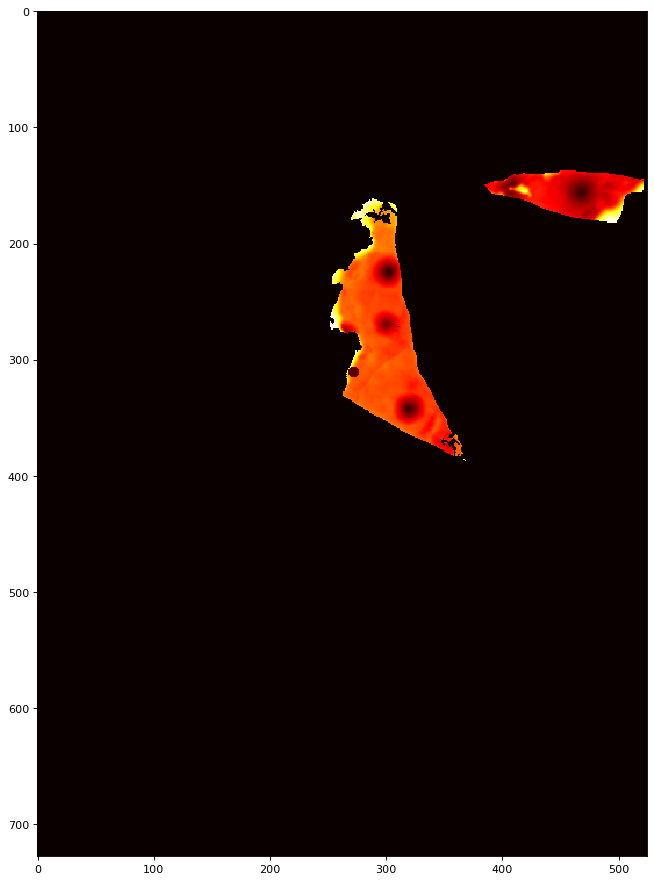

In [18]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(s_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

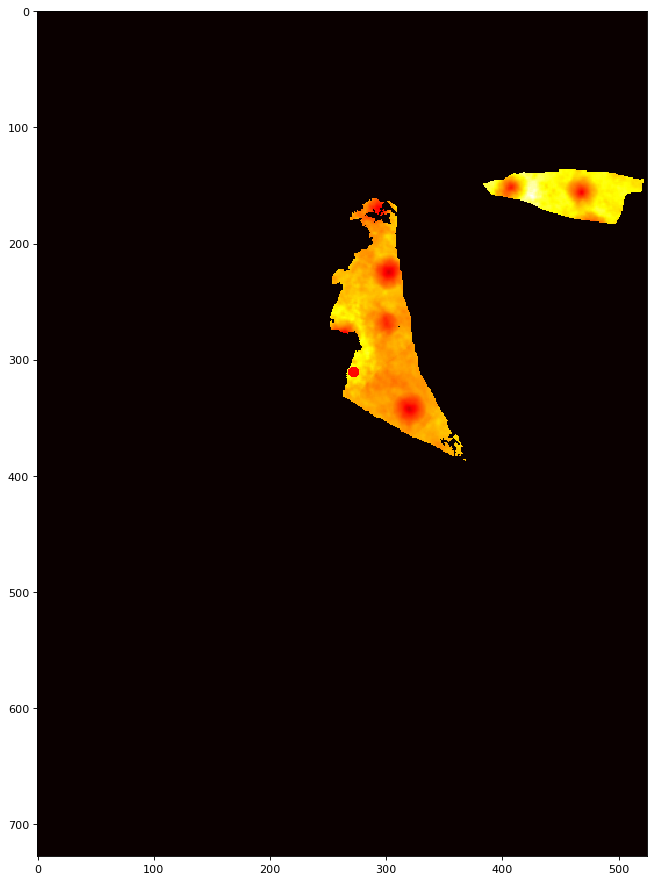

In [19]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(p_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

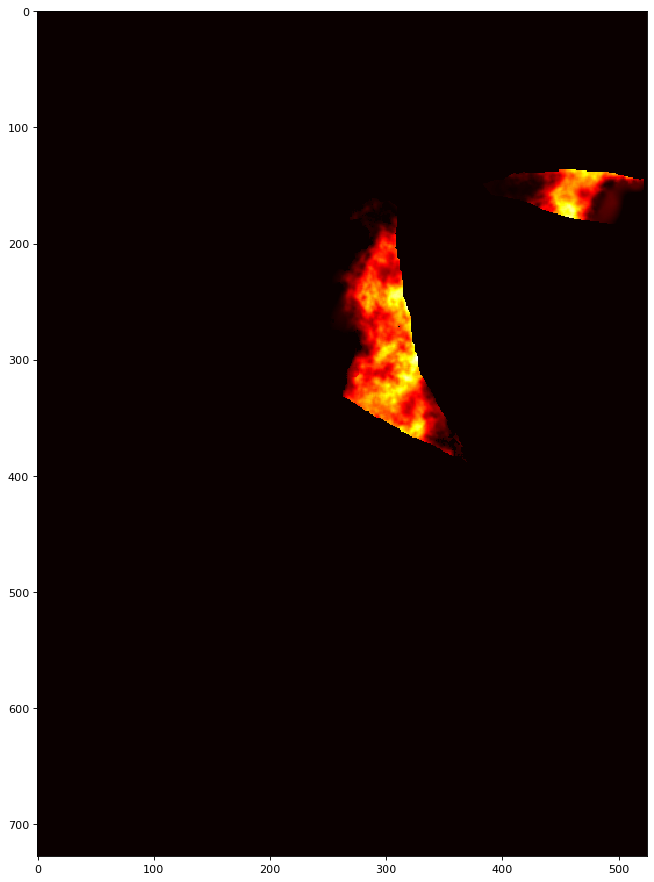

In [20]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(d_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

In [ ]:
files = ['non_zero_Saturation_zone_median', 'non_zero_Porosity_zone_median', 'non_zero_Depth_zone_median']
i = 0
for optimized_grid_values in [s_optimized_grid_values, p_optimized_grid_values, d_optimized_grid_values]:
    optimized_grid_values = np.fliplr(optimized_grid_values[::-1,::-1])
    p_lines = []
    p_lines.append(lines[0])
    p_lines.append(lines[1])
    p_lines.append(lines[2])
    p_lines.append(lines[3])

    s = ''
    b = 0
    for v in tqdm(optimized_grid_values):
        for x in v:
            b += 1
            if x == 0.0:
                x = 9999900.000000
            s += str(x)
            if b >= 6:
                b = 0
                p_lines.append(s)
                s = ''
            else:
                s += ' '
    print(len(p_lines) == len(lines))
    
    filename = files[i]
    
    print('Saving', filename, '...')
    with open(filename, 'a') as f:
        for l in p_lines:
            f.write(l+'\n')
            
    i += 1

### Nelder-mead algorithm

In [ ]:
x = np.arange(0, numX)
y = np.arange(0, numY)

In [ ]:
s_min_std = 1
p_min_std = 1
d_min_std = 1

s_well_coords = (0, 0)
p_well_coords = (0, 0)
d_well_coords = (0, 0)

s_optimized_grid_values = s_grid_values
p_optimized_grid_values = p_grid_values
d_optimized_grid_values = d_grid_values

for i in tqdm(range(0, len(s_grid_values))):
    for j in range(0, len(s_grid_values[i])):
        if s_grid_values[i][j] == 0.0 and p_grid_values[i][j] == 0.0 and d_grid_values[i][j] == 0.0:
            continue
        
        c_s_grid_values = s_grid_values.copy()
        c_p_grid_values = p_grid_values.copy()
        c_d_grid_values = d_grid_values.copy()
        
        cx = float(j)
        cy = float(i)
        mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
        sigmoid_rad = []
        for b in c_s_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_s_grid_values[mask] = sigmoid_rad
        c_s_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_p_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_p_grid_values[mask] = sigmoid_rad
        c_p_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_d_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_d_grid_values[mask] = sigmoid_rad
        c_d_grid_values[j][i] = 0.001
                
        plast_sum = np.sum(c_s_grid_values) / np.sum(s_grid_values)
        if s_min_std > plast_sum:
            s_optimized_grid_values = c_s_grid_values.copy()
            s_well_coords = (i, j)
            s_min_std = plast_sum
            
        plast_sum = np.sum(c_p_grid_values) / np.sum(p_grid_values)
        if p_min_std > plast_sum:
            p_optimized_grid_values = c_p_grid_values.copy()
            p_well_coords = (i, j)
            p_min_std = plast_sum
            
        plast_sum = np.sum(c_d_grid_values) / np.sum(d_grid_values)
        if d_min_std > plast_sum:
            d_optimized_grid_values = c_d_grid_values.copy()
            d_well_coords = (i, j)
            d_min_std = plast_sum

In [ ]:
x = min(s_well_coords[0], p_well_coords[0], d_well_coords[0])
y = min(s_well_coords[1], p_well_coords[1], d_well_coords[1])
result = minimize(objective, [x, y], method='nelder-mead')

In [ ]:
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

In [ ]:
well_coords = (int(solution[0]), int(solution[1]))

In [ ]:
x = np.arange(0, numX)
y = np.arange(0, numY)

In [ ]:
c_s_grid_values = s_grid_values.copy()
c_p_grid_values = p_grid_values.copy()
c_d_grid_values = d_grid_values.copy()
        
cx = float(well_coords[1])
cy = float(well_coords[0])
j, i = well_coords[0], well_coords[1]
mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
sigmoid_rad = []
for b in c_s_grid_values[mask]:
    sigmoid_rad.append(math.atan(b))
c_s_grid_values[mask] = sigmoid_rad
c_s_grid_values[j][i] = 0.001

sigmoid_rad = []
for b in c_p_grid_values[mask]:
    sigmoid_rad.append(math.atan(b))
c_p_grid_values[mask] = sigmoid_rad
c_p_grid_values[j][i] = 0.001
        
sigmoid_rad = []
for b in c_d_grid_values[mask]:
    sigmoid_rad.append(math.atan(b))
c_d_grid_values[mask] = sigmoid_rad
c_d_grid_values[j][i] = 0.001

s_optimized_grid_values = c_s_grid_values.copy()
p_optimized_grid_values = c_p_grid_values.copy()
d_optimized_grid_values = c_d_grid_values.copy()
s_well_coords = (cx, cy)
s_min_std = plast_sum

In [ ]:
print('OPTIMIZED')
print('d_saturation:', np.sum(s_grid_values) - np.sum(s_optimized_grid_values))
print('d_porosity:', np.sum(p_grid_values) - np.sum(p_optimized_grid_values))
print('d_depth:', np.sum(d_grid_values) - np.sum(d_optimized_grid_values))
print('d_all:', np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values) - np.sum(s_optimized_grid_values) - np.sum(p_optimized_grid_values) - np.sum(d_optimized_grid_values))
print('%saturation:', (1-(np.sum(s_optimized_grid_values) / np.sum(s_grid_values)))*100)
print('%porosity:', (1-(np.sum(p_optimized_grid_values) / np.sum(p_grid_values)))*100)
print('%depth:', (1-(np.sum(d_optimized_grid_values) / np.sum(d_grid_values)))*100)
print('%all:', (1 - (np.sum(s_optimized_grid_values) + np.sum(p_optimized_grid_values) + np.sum(d_optimized_grid_values)) / (np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values)))*100)

In [ ]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(s_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

In [ ]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(p_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

In [ ]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(d_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

In [ ]:
files = ['non_zero_Saturation nelder-mead', 'non_zero_Porosity nelder-mead', 'non_zero_Depth nelder-mead']
i = 0
for optimized_grid_values in [s_optimized_grid_values, p_optimized_grid_values, d_optimized_grid_values]:
    optimized_grid_values = np.fliplr(optimized_grid_values[::-1,::-1])
    p_lines = []
    p_lines.append(lines[0])
    p_lines.append(lines[1])
    p_lines.append(lines[2])
    p_lines.append(lines[3])

    s = ''
    b = 0
    for v in tqdm(optimized_grid_values):
        for x in v:
            b += 1
            if x == 0.0:
                x = 9999900.000000
            s += str(x)
            if b >= 6:
                b = 0
                p_lines.append(s)
                s = ''
            else:
                s += ' '
    print(len(p_lines) == len(lines))
    
    filename = files[i]
    
    print('Saving', filename, '...')
    with open(filename, 'a') as f:
        for l in p_lines:
            f.write(l+'\n')
            
    i += 1